In [8]:
from scripts.data_retrival import save_bar_data

Data saved to: data/INTC_1Min_2024-02-01_2025-02-01.csv



Total Return: -0.00%
Average Minute Return: -0.000000%
Minute Return Volatility: 0.000034%
Sharpe Ratio: -189.98
Maximum Drawdown: -0.01%


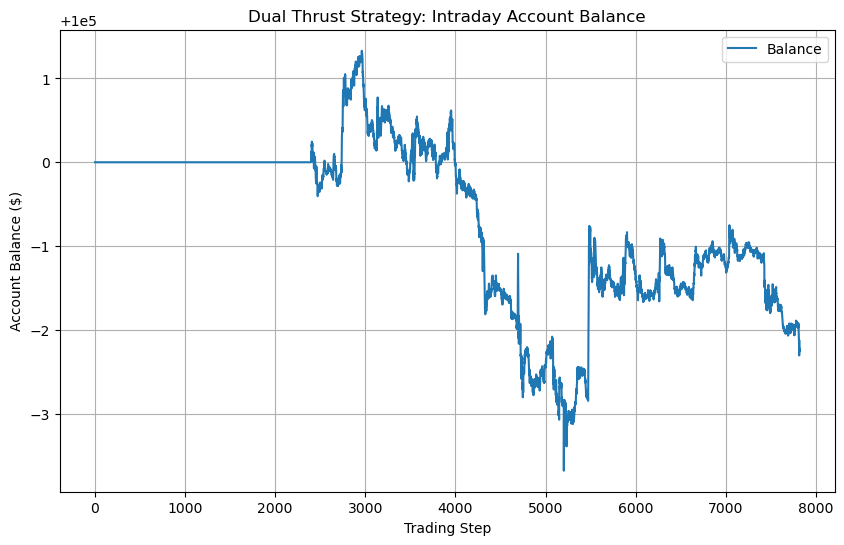

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('data/train_one_month.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df['date'] = df.index.date  # Extract date

# Define parameters (from RL environment)
window_size = 5
k1 = 0.5
k2 = 0.5
initial_balance = 100_000
transaction_cost = 2.3e-5
slippage = 0.2
risk_free_rate = 0.02  # Annual risk-free rate

# Compute daily summary
daily_df = df.groupby('date').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last'
})
daily_df.dropna(subset=['open', 'high', 'low', 'close'], inplace=True)

daily_df['HH'] = daily_df['high'].rolling(window=window_size).max()
daily_df['HC'] = daily_df['close'].rolling(window=window_size).max()
daily_df['LC'] = daily_df['close'].rolling(window=window_size).min()
daily_df['LL'] = daily_df['low'].rolling(window=window_size).min()

daily_df['Range'] = np.maximum(daily_df['HH'] - daily_df['LC'], daily_df['HC'] - daily_df['LL'])
daily_df['BuyLine'] = daily_df['open'] + k1 * daily_df['Range']
daily_df['SellLine'] = daily_df['open'] - k2 * daily_df['Range']

df = df.merge(daily_df[['BuyLine', 'SellLine']], left_on='date', right_index=True, how='left')
df['BuyLine'] = df['BuyLine'].ffill()
df['SellLine'] = df['SellLine'].ffill()

# **Backtest Dual Thrust Strategy**
balance = initial_balance
balances = []
minute_returns = []
position = 0  # 0 = no position, 1 = long, -1 = short
entry_price = 0

for i, row in df.iterrows():
    if pd.isna(row['BuyLine']):
        balances.append(balance)
        minute_returns.append(0)
        continue

    price_open = row['open']
    price_close = row['close']

    # Determine trade signal
    if price_open > row['BuyLine']:
        signal = 1  # Long
    elif price_open < row['SellLine']:
        signal = -1  # Short
    else:
        signal = position  # Hold previous position

    # **Execute Trade Logic**
    if signal != position:
        # Exit previous position
        if position != 0:
            exit_pnl = (price_open - entry_price) * position - abs(position) * transaction_cost * price_open
            balance += exit_pnl

        # Enter new position
        if signal != 0:
            entry_price = price_open

        position = signal  # Update position

    # Compute return at close
    pnl = (price_close - price_open) * position - abs(position) * transaction_cost * price_close
    balance += pnl
    minute_return = pnl / balance  # Return relative to balance
    minute_returns.append(minute_return)
    balances.append(balance)

# Convert to NumPy array
minute_returns = np.array(minute_returns)

# **Performance Metrics**
total_return = (balance - initial_balance) / initial_balance * 100
avg_minute_return = np.mean(minute_returns) * 100
volatility = np.std(minute_returns) * 100

# **Corrected Sharpe Ratio**
trading_minutes_per_year = 252 * 390  # 98,280 minutes
minute_risk_free_rate = risk_free_rate / trading_minutes_per_year  # Minute-based risk-free rate

excess_minute_returns = minute_returns - minute_risk_free_rate
sharpe_ratio = np.mean(excess_minute_returns) / np.std(minute_returns) * np.sqrt(trading_minutes_per_year)

# **Maximum Drawdown**
balances = np.array(balances)
peak_balance = np.maximum.accumulate(balances)
drawdowns = (balances - peak_balance) / peak_balance
max_drawdown = np.min(drawdowns) * 100

# **Print Metrics**
print(f"Total Return: {total_return:.2f}%")
print(f"Average Minute Return: {avg_minute_return:.6f}%")
print(f"Minute Return Volatility: {volatility:.6f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown:.2f}%")

# **Plot Balance Over Time**
plt.figure(figsize=(10,6))
plt.plot(balances, label="Balance")
plt.title("Dual Thrust Strategy: Intraday Account Balance")
plt.xlabel("Trading Step")
plt.ylabel("Account Balance ($)")
plt.legend()
plt.grid(True)
plt.show()

```One month is a short timeframe, so the Sharpe Ratio might be overestimated or underestimated due to market fluctuations.```

In [30]:
# Daily Sharpe Ratio
daily_sharpe_ratio = np.mean(excess_minute_returns) / np.std(minute_returns) * np.sqrt(390)

# Weekly Sharpe Ratio
weekly_sharpe_ratio = np.mean(excess_minute_returns) / np.std(minute_returns) * np.sqrt(390 * 5)

# Monthly Sharpe Ratio (since your data is one month long)
monthly_sharpe_ratio = np.mean(excess_minute_returns) / np.std(minute_returns) * np.sqrt(390 * 21)


In [34]:
daily_sharpe_ratio, weekly_sharpe_ratio, monthly_sharpe_ratio, daily_sharpe_ratio * np.sqrt(5)

(-11.967563889134299,
 -26.760286381176048,
 -54.842267406178024,
 -26.76028638117605)

Buy Signals:
                            open   BuyLine
timestamp                                 
2024-02-09 10:22:00-05:00  43.19  43.10915
2024-02-09 10:23:00-05:00  43.21  43.10915
2024-02-09 10:24:00-05:00  43.27  43.10915
2024-02-09 10:25:00-05:00  43.31  43.10915
2024-02-09 10:26:00-05:00  43.28  43.10915

Sell Signals:
                              open  SellLine
timestamp                                   
2024-02-21 10:39:00-05:00  43.5519     43.57
2024-02-21 10:40:00-05:00  43.5200     43.57
2024-02-21 10:41:00-05:00  43.5300     43.57
2024-02-21 10:42:00-05:00  43.5100     43.57
2024-02-21 10:43:00-05:00  43.4500     43.57


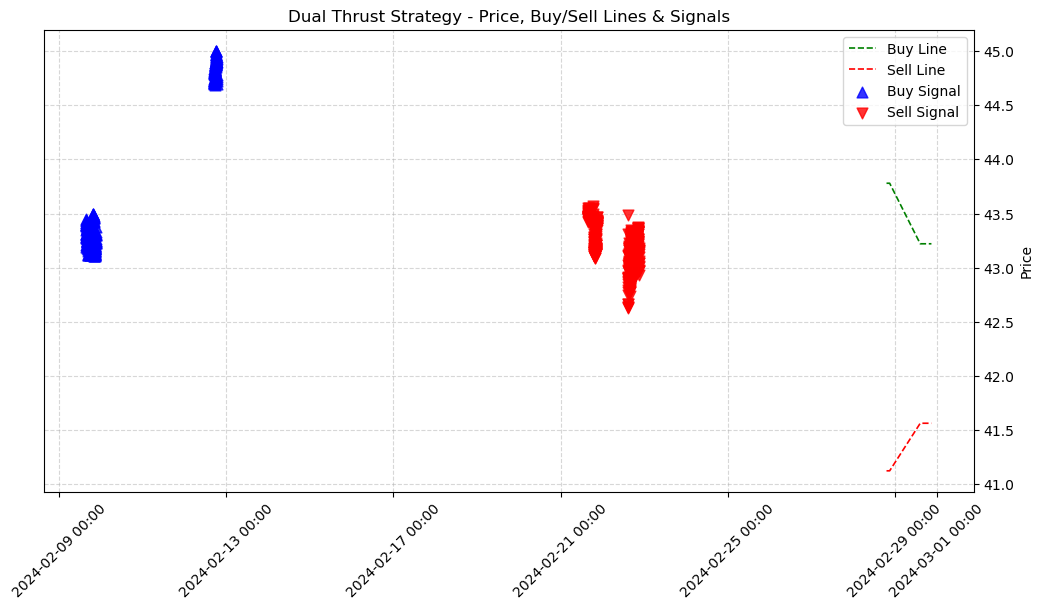

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import mplfinance as mpf

# Load Data
df = pd.read_csv('data/train_one_month.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)
df['date'] = df.index.date  # Extract date

# Define Parameters
window_size = 5
k1 = 0.5
k2 = 0.5

# Compute Daily Summary
daily_df = df.groupby('date').agg({
    'open': 'first',
    'high': 'max',
    'low': 'min',
    'close': 'last'
})
daily_df.dropna(subset=['open', 'high', 'low', 'close'], inplace=True)

daily_df['HH'] = daily_df['high'].rolling(window=window_size).max()
daily_df['HC'] = daily_df['close'].rolling(window=window_size).max()
daily_df['LC'] = daily_df['close'].rolling(window=window_size).min()
daily_df['LL'] = daily_df['low'].rolling(window=window_size).min()

daily_df['Range'] = np.maximum(daily_df['HH'] - daily_df['LC'], daily_df['HC'] - daily_df['LL'])
daily_df['BuyLine'] = daily_df['open'] + k1 * daily_df['Range']
daily_df['SellLine'] = daily_df['open'] - k2 * daily_df['Range']

# Merge with Minute Data
df = df.merge(daily_df[['BuyLine', 'SellLine']], left_on='date', right_index=True, how='left')
df['BuyLine'] = df['BuyLine'].ffill()
df['SellLine'] = df['SellLine'].ffill()

# Identify Buy and Sell Signals
df['Signal'] = 0
df.loc[df['open'] > df['BuyLine'], 'Signal'] = 1  # Buy Signal
df.loc[df['open'] < df['SellLine'], 'Signal'] = -1  # Sell Signal

# Extract Buy and Sell Points for Plotting
buy_signals = df[df['Signal'] == 1]
sell_signals = df[df['Signal'] == -1]

# Print Buy/Sell Signals (Sanity Check)
print("Buy Signals:")
print(buy_signals[['open', 'BuyLine']].head())

print("\nSell Signals:")
print(sell_signals[['open', 'SellLine']].head())

# Limit data to last 500 points for better visualization
df_plot = df[['open', 'high', 'low', 'close']].iloc[-500:]
buy_line = df['BuyLine'].iloc[-500:]
sell_line = df['SellLine'].iloc[-500:]

# Set up figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot candlestick chart
mpf.plot(df_plot, type='candle', style='charles', ax=ax)

# Plot Buy and Sell Lines
ax.plot(buy_line.index, buy_line, color='green', linestyle='dashed', label='Buy Line', linewidth=1.2)
ax.plot(sell_line.index, sell_line, color='red', linestyle='dashed', label='Sell Line', linewidth=1.2)

# Add Buy and Sell Signals as Triangles
ax.scatter(buy_signals.index, buy_signals['open'], color='blue', marker='^', label='Buy Signal', alpha=0.8, s=60)
ax.scatter(sell_signals.index, sell_signals['open'], color='red', marker='v', label='Sell Signal', alpha=0.8, s=60)

# Formatting
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())
plt.xticks(rotation=45)
plt.legend()
plt.title("Dual Thrust Strategy - Price, Buy/Sell Lines & Signals")
plt.ylabel("Price")
plt.grid(True, linestyle="--", alpha=0.5)

# Show the plot
plt.show()